# Benchmark a year pixel drill

In [1]:
import dask.bag as db
import dask
from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, visualize

In [2]:
import xarray as xr
import fsspec
import glob
xr.set_options(display_style='text');

In [3]:
references = sorted(glob.glob('./refs/2020*_night.json'))
len(references)

326

In [4]:
def open_zarr(r):
    m = fsspec.get_mapper("reference://", 
                              remote_protocol='s3',
                    fo=r, remote_options={'anon':True,'skip_instance_cache':True,'use_listings_cache':False})
    ds = xr.open_zarr(m)
    return ds

In [5]:
b = db.from_sequence(references,npartitions=36)
zarrs = b.map(open_zarr)
with dask.config.set(scheduler='processes'): 
    with ProgressBar(), Profiler() as prof, ResourceProfiler(dt=0.25) as rprof:
        zarrs = zarrs.compute()

[########################################] | 100% Completed | 60.0s


In [6]:
# view profiler results (creates profile.html)
visualize([prof, rprof])

Column(id='1125', ...)

In [7]:
zarrs = [z.drop_vars(['sea_ice_fraction', 'sea_ice_fraction_dtime_from_sst'], errors='ignore') for z in zarrs]

In [8]:
## %%time
ds = xr.concat(zarrs,dim='time',coords='minimal',compat='override',combine_attrs='override', fill_value='')

In [9]:
# let's have a look at the structure of this dataset
ds

<xarray.Dataset>
Dimensions:                    (time: 326, lat: 4500, lon: 6000)
Coordinates:
  * lat                        (lat) float32 19.99 19.97 19.95 ... -69.97 -69.99
  * lon                        (lon) float32 70.01 70.03 70.05 ... 190.0 190.0
  * time                       (time) datetime64[ns] 2020-01-01T15:20:00 ... ...
Data variables:
    dt_analysis                (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    l2p_flags                  (time, lat, lon) float32 dask.array<chunksize=(1, 1500, 2000), meta=np.ndarray>
    quality_level              (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    satellite_zenith_angle     (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    sea_surface_temperature    (time, lat, lon) float32 dask.array<chunksize=(1, 1500, 2000), meta=np.ndarray>
    sses_bias                  (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    sses_count                 (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    sses_standard_deviation    (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    sst_dtime                  (time, lat, lon) float64 dask.array<chunksize=(1, 1500, 2000), meta=np.ndarray>
    wind_speed                 (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
    wind_speed_dtime_from_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 2250, 3000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Metadata_Link:              TBA
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              grid
    comment:                    HRPT AVHRR experimental L3 retrieval produced...
    ...                         ...
    summary:                    Skin SST retrievals produced from stitching t...
    time_coverage_end:          20200101T132554Z
    time_coverage_start:        20200101T095516Z
    title:                      IMOS L3S Nighttime gridded multiple-sensor mu...
    uuid:                       d192f263-384c-4907-a892-1a5b71630838
    westernmost_longitude:      70.01000213623047

In [10]:
with dask.config.set(scheduler='threads'):
    with ProgressBar(), Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
        timeseries = ds.sel(lat=-32.45,lon=115.55,method='nearest').compute()

[########################################] | 100% Completed |  3min 21.0s


In [11]:
visualize([prof, rprof, cprof])

Column(id='1657', ...)

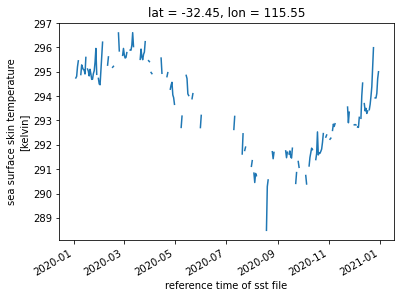

In [12]:
timeseries.sea_surface_temperature.plot()

## Convert To NetCDF

In [ ]:
%%time
timeseries.to_netcdf('timeseries.nc')